# Collection of Analysis Related to GPS
This notebook contains the analysis for GPS related confirmations scattered
throughout other jupyter notebooks. The purpose of this notebook is to make the
information related to Sensor Confirmation pairs utilizing the GPS easier to
find during the writing of the GPS Sensor Confirmation paper.

The data files can be found in the data subdirectory. Only interim data will be
available on github to preserve storage. For raw log files please contact me at
srimoungchanh.bailey@ku.edu.

## Loading Benign Data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import numpy as np
from confirmation.process import process_SNS
from os.path import exists

#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "Live-C-Delivery.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR", "rf", "m00", "m10"]].reset_index()
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()

### Velocity

In [2]:
from confirmation.process import geodetic2ned, change_in_signal

gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = change_in_signal(gps.North)/(gpsMS.gpsMS.diff().mean()/1000)
gps_east = change_in_signal(gps.East)/(gpsMS.gpsMS.diff().mean()/1000)
gps_down = change_in_signal(gps.Down/100)/(gpsMS.gpsMS.diff().mean()/1000)

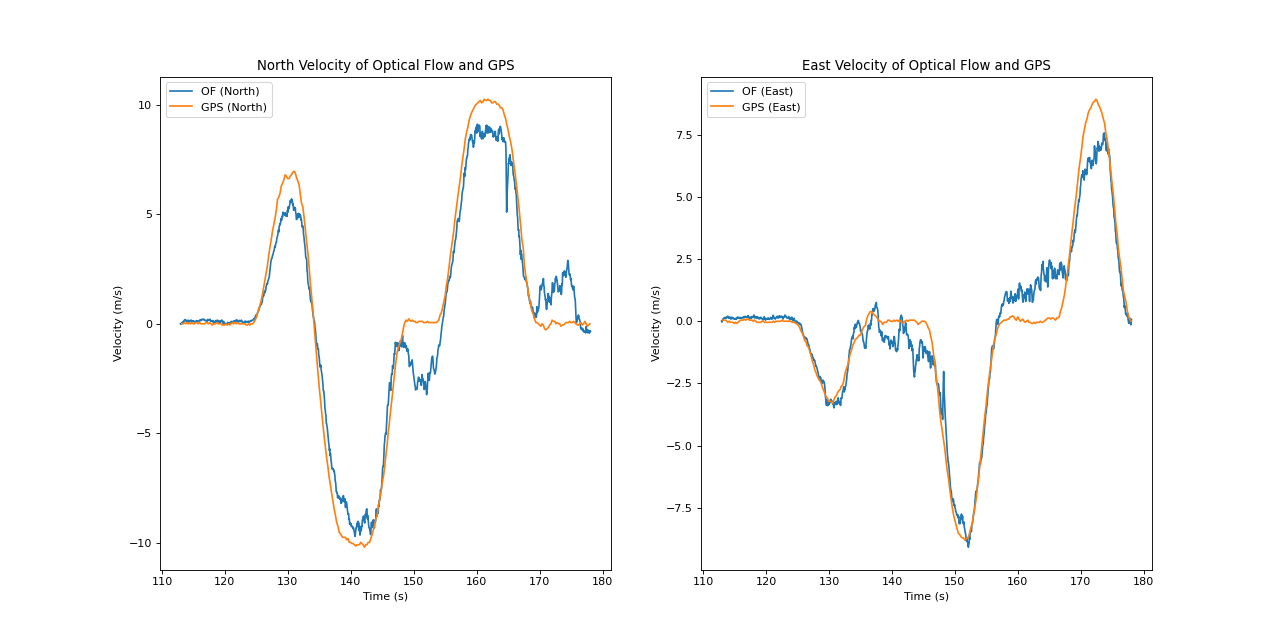

In [3]:
from confirmation.process import length, body_to_earth2D, low_pass_filter
import matplotlib.pyplot as plt

#Convert optical flow and rangefinder to OF Velocity in body frame
of_vel_bf = pd.DataFrame(data={"OF Forward":(ofMS.frF - ofMS.brF) * ofMS.rf/100,
                               "OF Right":(ofMS.frR - ofMS.brR) * ofMS.rf/100})

earth_frame = body_to_earth2D(of_vel_bf["OF Forward"], of_vel_bf["OF Right"], ofMS.m00, ofMS.m10)

lpf_E = -low_pass_filter(earth_frame.East, alpha=0.2)
lpf_N = low_pass_filter(earth_frame.North, alpha=0.2)

plt.figure(1, figsize=(16, 8), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(ofMS.ofMS/1000, lpf_N, label="OF (North)")
plt.plot(gpsMS.gpsMS[1:]/1000, gps_north, label="GPS (North)")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("North Velocity of Optical Flow and GPS")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(ofMS.ofMS/1000, lpf_E, label="OF (East)")
plt.plot(gpsMS.gpsMS[1:]/1000, gps_east, label="GPS (East)")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("East Velocity of Optical Flow and GPS")
plt.legend()
plt.show()

### Altitude

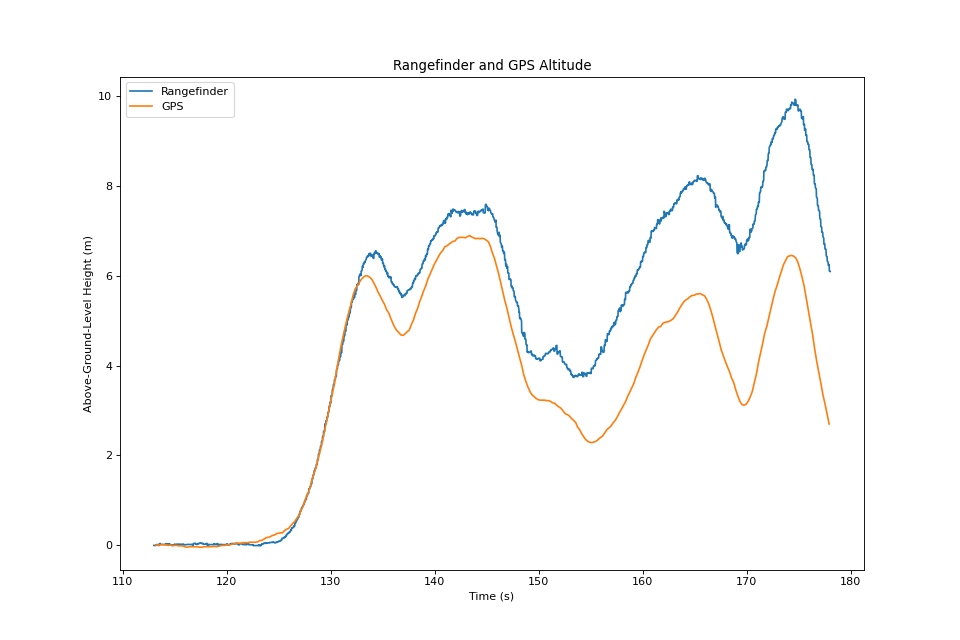

In [4]:
from confirmation.process import linear_bias

#Rangefinder
rfMS = df[df.rfMS.shift() != df.rfMS][["rfMS","rf","m22"]].reset_index(drop=True)
tilt_compensated_rf = []
for reading in range(len(rfMS)):
    tilt_compensated_rf.append(max(rfMS.m22[reading], 0.707) * rfMS.rf[reading])
tilt_compensated_rf = pd.Series(tilt_compensated_rf, name="Rangefinder")
rf_alt = tilt_compensated_rf/100

#GPS
gps_alt = change_in_signal(gpsMS.gpAlt/100)

plt.figure(2, figsize=(12, 8), dpi=80)
plt.subplot(1, 1, 1)
plt.plot(rfMS.rfMS/1000, rf_alt-rf_alt[0], label="Rangefinder")
plt.plot(gpsMS.gpsMS[1:]/1000, gps_alt.cumsum(), label="GPS")
plt.xlabel("Time (s)")
plt.ylabel("Above-Ground-Level Height (m)")
plt.title("Rangefinder and GPS Altitude")
plt.legend()
plt.show()

### Heading/Ground Course

The Heading/Ground Course shown is shifted for visibility. The values shown are not the true Heading/Ground Course.


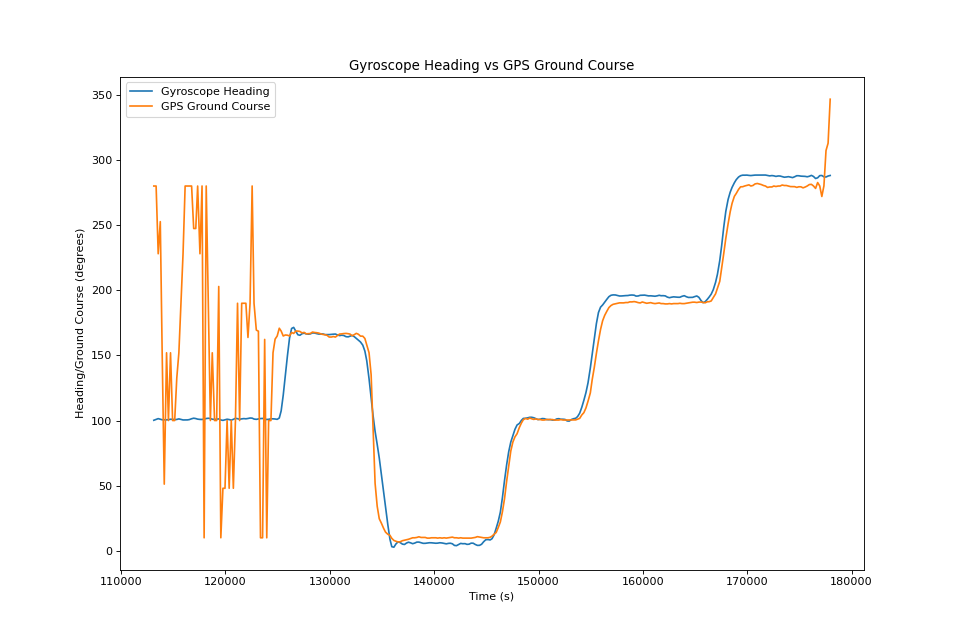

In [5]:
from math import degrees, atan2
from confirmation.process import trap_integrate, signal_match_and_cumsum

#GPS derived ground course
gps_gc = []
for reading in range(len(gps_north)):
    gps_gc.append(degrees(atan2(gps_east[reading], gps_north[reading])) % 360)
gps_gc = pd.Series(gps_gc, name="GPS Ground Course")

#Matching gyroscope to the optical flow update rate
gyr_heading = trap_integrate(cUS.cUS / 1000000, cUS.gyrz).apply(degrees).cumsum() % 360
gyr_gps_heading = signal_match_and_cumsum(cUS.cUS.reset_index(drop=True)/1000, change_in_signal(gyr_heading),
                                          gpsMS.gpsMS[1:].reset_index(drop=True), change_in_signal(gps_gc))
gyr_gps_heading = pd.Series(gyr_gps_heading, name="Gyroscope Heading")
gyr_gps_heading = (gyr_gps_heading-90)%360

plt.figure(3, figsize=(12, 8), dpi=80)
plt.subplot(1, 1, 1)
plt.plot(gpsMS.gpsMS[1:], (gyr_gps_heading-170)%360, label="Gyroscope Heading")
plt.plot(gpsMS.gpsMS[1:], (gps_gc-170)%360, label="GPS Ground Course")
plt.xlabel("Time (s)")
plt.ylabel("Heading/Ground Course (degrees)")
plt.title("Gyroscope Heading vs GPS Ground Course")
plt.legend()
print("The Heading/Ground Course shown is shifted for visibility. The values shown are not the true Heading/Ground Course.")
plt.show()

## Loading Malicious Data

In [6]:
#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "Live-C-Idle-Attack-2000-0_4.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR", "rf", "m00", "m10"]].reset_index()
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()

attack_end = 170 #seconds
attack_start = 163 #seconds

### Velocity

In [7]:
gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = change_in_signal(gps.North)/(gpsMS.gpsMS.diff().mean()/1000)
gps_east = change_in_signal(gps.East)/(gpsMS.gpsMS.diff().mean()/1000)
gps_down = change_in_signal(gps.Down/100)/(gpsMS.gpsMS.diff().mean()/1000)

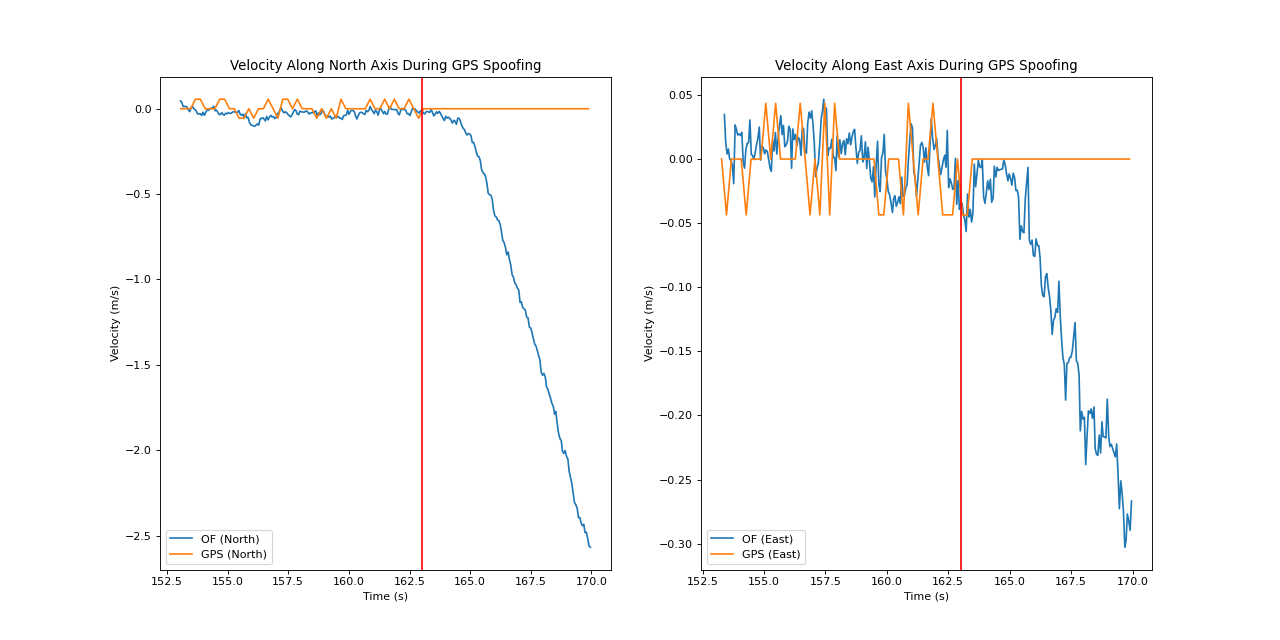

In [8]:
#Convert optical flow and rangefinder to OF Velocity in body frame
of_vel_bf = pd.DataFrame(data={"OF Forward":(ofMS.frF - ofMS.brF) * ofMS.rf/100,
                               "OF Right":(ofMS.frR - ofMS.brR) * ofMS.rf/100})

earth_frame = body_to_earth2D(of_vel_bf["OF Forward"], of_vel_bf["OF Right"], ofMS.m00, ofMS.m10)

lpf_E = -low_pass_filter(earth_frame.East, alpha=0.2)
lpf_N = low_pass_filter(earth_frame.North, alpha=0.2)

plt.figure(4, figsize=(16, 8), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(ofMS.ofMS[:(ofMS.ofMS < attack_end*1000).sum()]/1000, lpf_N[:(ofMS.ofMS < attack_end*1000).sum()]-lpf_N[10], label="OF (North)")
plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end*1000).sum()]/1000, gps_north[:(gpsMS.gpsMS < attack_end*1000).sum()], label="GPS (North)")
plt.axvline(163, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along North Axis During GPS Spoofing")
plt.legend(loc='lower left')
plt.subplot(1, 2, 2)
plt.plot(ofMS.ofMS[6:(ofMS.ofMS < attack_end*1000).sum()]/1000, lpf_E[6:(ofMS.ofMS < attack_end*1000).sum()]-lpf_E[10], label="OF (East)")
plt.plot(gpsMS.gpsMS[1:(gpsMS.gpsMS < attack_end*1000).sum()]/1000, gps_east[1:(gpsMS.gpsMS < attack_end*1000).sum()], label="GPS (East)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along East Axis During GPS Spoofing")
plt.legend(loc='lower left')
plt.show()

### Altitude

### Heading/Ground Course